In [1]:
%load_ext autoreload
%autoreload 2

import gstools as gs
import intake
import os
import zarr
import pandas as pd
import xarray as xr
import intake_esm
import numpy as np
from dask.distributed import Client
from cmip6_downscaling import CLIMATE_NORMAL_PERIOD
from cmip6_downscaling.constants import KELVIN, PERCENT, SEC_PER_DAY
import rioxarray
from rasterio.enums import Resampling
from cmip6_downscaling.workflows.share import (
    chunks,
    future_time,
    get_cmip_runs,
    hist_time,
    xy_region,
)
from cmip6_downscaling.workflows.utils import get_store
import matplotlib.pyplot as plt
intake_esm.__version__

'2021.1.15'

In [2]:
import skdownscale

In [3]:
skdownscale.__file__

'/home/jovyan/scikit-downscale/skdownscale/__init__.py'

# access GCM data

will be replaced by `load_cmip_dictionary` and `gcm_munge`

In [4]:
activity_ids = ["CMIP", "ScenarioMIP"]
experiment_ids = ["historical", "ssp370"] #, "ssp126", "ssp245",  "ssp585"
member_ids = ["r1i1p1f1"]
source_ids = ["CanESM5"]#BCC-CSM2-MR"]
table_ids = ["day"]
grid_labels = ["gn"]
variable = 'tasmax'
variable_ids = [variable] #tasmax, tasmin, pr

In [5]:
col_url = "https://cmip6downscaling.blob.core.windows.net/cmip6/pangeo-cmip6.json"

col = intake.open_esm_datastore(col_url)
full_subset = col.search(
    activity_id=activity_ids,
    experiment_id=experiment_ids, 
    member_id=member_ids,
    table_id=table_ids,
    grid_label=grid_labels,
    variable_id=variable_ids,
    source_id=source_ids
)

In [6]:
gcm_ds_dict = full_subset.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}, 
    storage_options={'account_name':'cmip6downscaling',
                     'account_key':os.environ.get('AccountKey', None)}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [7]:
gcm_ds_dict.keys()

dict_keys(['ScenarioMIP.CCCma.CanESM5.ssp370.day.gn', 'CMIP.CCCma.CanESM5.historical.day.gn'])

In [8]:
full_gcm = xr.combine_by_coords(list(gcm_ds_dict.values()), combine_attrs='drop')
full_gcm = full_gcm.squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds'])
if full_gcm.lat[0] < full_gcm.lat[-1]:
    full_gcm = full_gcm.reindex({'lat': full_gcm.lat[::-1]})
full_gcm = full_gcm.rio.write_crs('EPSG:4326')
# full_gcm = full_gcm.assign_coords({'time': full_gcm.indexes['time'].to_datetimeindex()})

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [9]:
full_gcm

<xarray.Dataset>
Dimensions:      (lat: 64, lon: 128, time: 91615)
Coordinates:
  * lat          (lat) float64 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
  * lon          (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time         (time) object 1850-01-01 12:00:00 ... 2100-12-31 12:00:00
    spatial_ref  int64 0
Data variables:
    tasmax       (time, lat, lon) float32 dask.array<chunksize=(1879, 64, 128), meta=np.ndarray>
Attributes:
    grid_mapping:  spatial_ref

# access obs data

to be replaced by `open_era5`

In [10]:
# converts cmip standard names to ERA5 names
variable_name_dict = {
    'tasmax': 'air_temperature_at_2_metres_1hour_Maximum',
    'tasmin': 'air_temperature_at_2_metres_1hour_Minimum',
    'pr': 'precipitation_amount_1hour_Accumulation'
}

In [11]:
def get_store(bucket, prefix, account_key=None):
    ''' helper function to create a zarr store'''

    if account_key is None:
        account_key = os.environ.get('AccountKey', None)

    store = zarr.storage.ABSStore(
        bucket,
        prefix=prefix,
        account_name="cmip6downscaling",
        account_key=account_key
    )
    return store

def open_era5(var):
    col = intake.open_esm_datastore("https://cmip6downscaling.blob.core.windows.net/cmip6/ERA5_catalog.json")
    subset = col.search(variable=variable_name_dict[var], year=np.arange(1980, 1990))
    era5_stores = [store.split('az://cmip6/')[1] for store in subset.df.zstore.values]
    store_list = [get_store(bucket='cmip6', prefix=prefix) for prefix in era5_stores]
    ds = xr.open_mfdataset(store_list, engine='zarr', concat_dim='time').drop('time1_bounds')
    return ds

In [12]:
# full_obs = open_era5(variable)
# full_obs = full_obs.rio.write_crs('EPSG:4326')

# specify spatial regional subset and time periods

In [13]:
def convert_to_360(lon):
    if lon > 0:
        return lon
    elif lon < 0:
        return 360+lon
    
def load_coords(ds: xr.Dataset) -> xr.Dataset:
    '''helper function to pre-load coordinates'''
    ds = ds.update(ds[list(ds.coords)].load())
    for v in ds.variables:
        if 'chunks' in ds[v].encoding:
            del ds[v].encoding['chunks']

    return ds

In [14]:
# variable names
bc_vars = ['tasmin', 'tasmax', 'ppt', 'srad', 'rh']
update_vars = ['area', 'crs', 'mask']
extrapolate = {'tasmin': '1to1', 'tasmax': '1to1', 'ppt': '1to1', 'srad': '1to1', 'rh': '1to1'}

In [15]:
# parameters
train_slice = slice('1980', '1984')  # train time range
holdout_slice = slice('1984', '1989')  # prediction time range

# bounding box of downscaling region
min_lon, max_lon = -124.8, -120.
lon_slice = slice(convert_to_360(min_lon), convert_to_360(max_lon))
min_lat, max_lat = 45, 50
lat_slice = slice(max_lat, min_lat)

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

In [16]:
buffer = 3
buffer_slice_lat = slice(max_lat + buffer, min_lat - buffer)
buffer_slice_lon = slice(convert_to_360(min_lon) - buffer, convert_to_360(max_lon) + buffer)
buffer_slice_time = slice(train_slice.start, holdout_slice.stop)

In [17]:
gcm_slice = full_gcm.sel(lon=lon_slice, lat=lat_slice, time=buffer_slice_time)

In [18]:
# obs_buffer = full_obs.sel(time=buffer_slice_time, lat=buffer_slice_lat, lon=buffer_slice_lon)

In [19]:
# obs_buffer = obs_buffer.chunk({'lat': 10, 'lon': 10, 'time': 1000})
# for v in obs_buffer:
#     print(v)
#     if 'chunks' in obs_buffer[v].encoding:
#         del obs_buffer[v].encoding['chunks']
# obs_buffer.to_zarr('obs_buffer.zarr', mode='w')

In [20]:
obs_buffer = xr.open_zarr('obs_buffer.zarr')
obs_buffer = obs_buffer.resample(time='1D').max().rename({variable_name_dict[variable]:variable})
obs_buffer

,Array,Chunk
Bytes,28.93 MB,400 B
Shape,"(3653, 45, 44)","(1, 10, 10)"
Count,461726 Tasks,91325 Chunks
Type,float32,numpy.ndarray


In [21]:
coord_rename_dict = {'lon': 'x', 'lat': 'y'}
coord_rename_dict_reverse = {'x': 'lon', 'y': 'lat'}

In [22]:
coarse_obs = obs_buffer.rename(coord_rename_dict).rio.reproject_match(
    gcm_slice.isel(time=0).rename(coord_rename_dict), 
    resampling=Resampling.bilinear
)

In [23]:
coarse_obs.isel(time=0).tasmax.values

array([[278.3866 , 274.2222 ],
       [282.08112, 276.9598 ]], dtype=float32)

In [24]:
coarse_obs = coarse_obs.rename(coord_rename_dict_reverse)

In [25]:
obs = obs_buffer.sel(lat=lat_slice, lon=lon_slice)#.load(scheduler='threads').chunk(chunks)

# MACA

* technically for maca we should be interpolating both gcm and obs to 1 degree grid 
* simlifying to interpolating to gcm grids 

In [26]:
gcm_slice

<xarray.Dataset>
Dimensions:      (lat: 2, lon: 2, time: 3650)
Coordinates:
  * lat          (lat) float64 48.84 46.04
  * lon          (lon) float64 236.2 239.1
  * time         (time) object 1980-01-01 12:00:00 ... 1989-12-31 12:00:00
    spatial_ref  int64 0
Data variables:
    tasmax       (time, lat, lon) float32 dask.array<chunksize=(1404, 2, 2), meta=np.ndarray>
Attributes:
    grid_mapping:  spatial_ref

In [27]:
coarse_obs

<xarray.Dataset>
Dimensions:      (lat: 2, lon: 2, time: 3653)
Coordinates:
  * lon          (lon) float64 236.2 239.1
  * lat          (lat) float64 48.84 46.04
  * time         (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1989-12-31
    spatial_ref  int64 0
Data variables:
    tasmax       (time, lat, lon) float32 278.4 274.2 282.1 ... 282.1 278.4

In [28]:
obs

<xarray.Dataset>
Dimensions:      (lat: 21, lon: 20, time: 3653)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1989-12-31
  * lat          (lat) float32 50.0 49.75 49.5 49.25 ... 45.75 45.5 45.25 45.0
  * lon          (lon) float32 235.2 235.5 235.8 236.0 ... 239.5 239.8 240.0
    spatial_ref  int64 ...
Data variables:
    tasmax       (time, lat, lon) float32 dask.array<chunksize=(1, 8, 8), meta=np.ndarray>

## Epoch Adjustment

In [29]:
day_rolling_window = 21
year_rolling_window = 3

# historical_period = slice('1980', '2010')
# future_period = slice('2010', '2050')
# gcm_slice = gcm_slice.sel(time=slice(historical_period.start, future_period.stop))

In [30]:
def add_circular_temporal_pad(data, offset, timeunit='D'):
    """
    pad the beginning of data with the last values of data, and pad the end of data with the first values of data 
    
    data must have a dimension called time 
    """
    
    padded = data.pad(time=offset, mode='wrap')

    time_coord = padded.time.values
    time_coord[:offset] = (data.time[:offset] - pd.Timedelta(offset, timeunit)).values
    time_coord[-offset:] = (data.time[-offset:] + pd.Timedelta(offset, timeunit)).values

    padded = padded.assign_coords({'time': time_coord})
    
    return padded

def days_in_year(year, use_leap_year=False):
    if (year % 4 == 0) and use_leap_year:
        return 366
    return 365
    # there might be calendars with 360 days 

def pad_with_edge_year(data):
    """
    pad data with repeating values at the edge, similar to the behavior of np.pad(mode='edge') but uses the 365 edge values 
    instead of repeating only 1 edge value (366 if leap year)
    
    offset is the number of years to pad on each side
    data must have a dimension called time 
    """
    def pad_with(vector, pad_width, iaxis, kwargs):
        pstart = pad_width[0]
        pend = pad_width[1]
        if pstart > 0:
            start = vector[pstart:pstart*2]
            vector[:pstart] = start
        if pend > 0:
            end = vector[-pend*2:-pend]
            vector[-pend:] = end
        
    prev_year = days_in_year(data.time[0].dt.year.values - 1)
    next_year = days_in_year(data.time[-1].dt.year.values + 1)
    padded = data.pad({'time':(prev_year, next_year)}, mode=pad_with)
    time_coord = padded.time.values
    time_coord[:prev_year] = (data.time[:prev_year] - pd.Timedelta(prev_year, 'D')).values
    time_coord[-next_year:] = (data.time[-next_year:] + pd.Timedelta(next_year, 'D')).values
    
    padded = padded.assign_coords({'time': time_coord})
    
    return padded

In [31]:
def epoch_adjustment(data, historical_period, day_rolling_window=21, year_rolling_window=31):
    """
    data must have a dimension called time 
    """

    assert day_rolling_window % 2 == 1
    d_offset = int((day_rolling_window - 1) / 2)

    assert year_rolling_window % 2 == 1
    y_offset = int((year_rolling_window - 1) / 2)
    
    # get historical average rolling average 
    padded = add_circular_temporal_pad(
        data=data.sel(time=historical_period),
        offset=d_offset
    )
    hist_mean = padded.rolling(time=day_rolling_window, center=True).mean().dropna('time').groupby("time.dayofyear").mean()
    
    # get rolling average for the entire data  
    padded = add_circular_temporal_pad(
        data=data,
        offset=d_offset
    )
    func = lambda x: x.rolling(time=year_rolling_window, center=True).mean()
    rolling_doy_mean = padded.rolling(time=day_rolling_window, center=True).mean().dropna('time').groupby('time.dayofyear').apply(func).dropna('time')
    
    rolling_doy_mean = rolling_doy_mean.load()
    
    # repeat the first/last year   
    for i in range(y_offset): 
        rolling_doy_mean = pad_with_edge_year(rolling_doy_mean)
                
    trend = (rolling_doy_mean.groupby('time.dayofyear') - hist_mean)
    print(data)
    print(data.tasmax.isel(time=0).values)
    print(trend)
    print(trend.tasmax.isel(time=0).values)
    ea_data = data - trend
    print(ea_data)
    print(ea_data.tasmax.isel(time=0).values)
        
    return ea_data, trend

In [32]:
ea_gcm_slice, trend = epoch_adjustment(
    gcm_slice, 
    historical_period=train_slice,
    day_rolling_window=day_rolling_window,
    year_rolling_window=year_rolling_window
)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:      (lat: 2, lon: 2, time: 3650)
Coordinates:
  * lat          (lat) float64 48.84 46.04
  * lon          (lon) float64 236.2 239.1
  * time         (time) object 1980-01-01 12:00:00 ... 1989-12-31 12:00:00
    spatial_ref  int64 0
Data variables:
    tasmax       (time, lat, lon) float32 dask.array<chunksize=(1404, 2, 2), meta=np.ndarray>
Attributes:
    grid_mapping:  spatial_ref
[[279.987   275.45862]
 [281.76535 279.33878]]
<xarray.Dataset>
Dimensions:      (lat: 2, lon: 2, time: 3650)
Coordinates:
  * lat          (lat) float64 48.84 46.04
  * lon          (lon) float64 236.2 239.1
  * time         (time) object 1980-01-01 12:00:00 ... 1989-12-31 12:00:00
    spatial_ref  int64 0
    dayofyear    (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    tasmax       (time, lat, lon) float32 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
[[1.4814148  1.8241882 ]
 [0.99871826 1.8378296 ]]
<xarray.Dataset>
Dimensions:      (lat: 

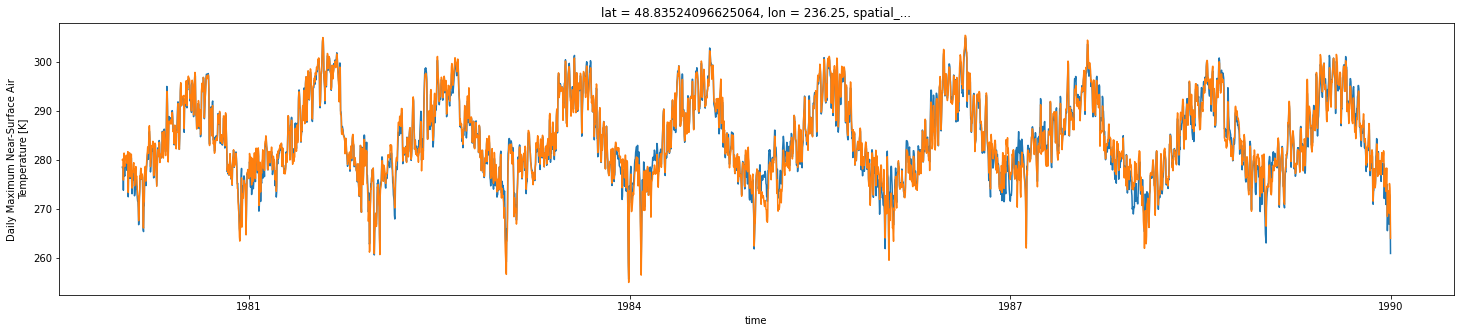

In [33]:
i = 0
plt.figure(figsize=(25, 5))
ea_gcm_slice.isel(lat=i, lon=i).tasmax.plot(ax=plt.gca(), label='epoch adjusted')
gcm_slice.isel(lat=i, lon=i).tasmax.plot(ax=plt.gca(), label='original')

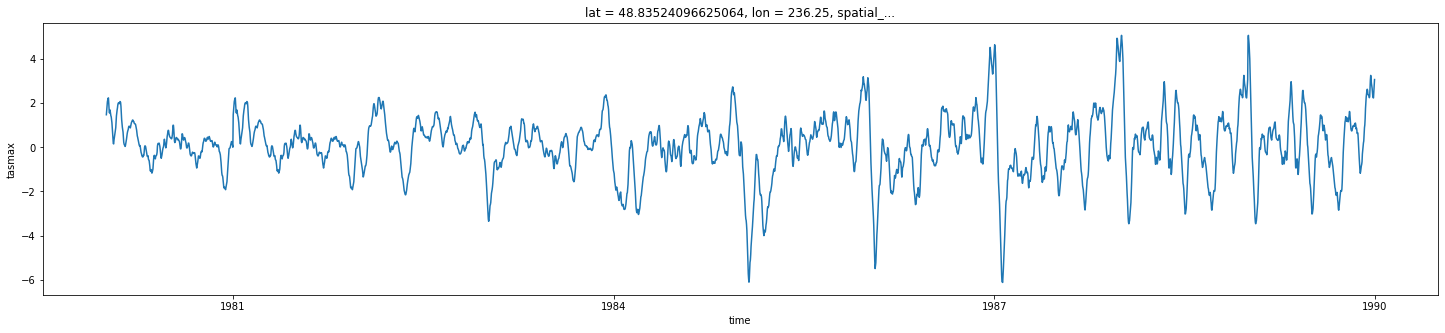

In [34]:
plt.figure(figsize=(25, 5))
trend.isel(lat=i, lon=i).tasmax.plot(ax=plt.gca())

## coarse scale bias correction 

In [35]:
from skdownscale.pointwise_models import PointWiseDownscaler, EquidistantCdfMatcher 

In [36]:
def generate_batches(n, batch_size, buffer_size, one_indexed=False):
    """
    ds must have a dimension called time that is a valid datetime index 
    """
    cores = []
    batches = []
    if one_indexed:
        xmin = 1
        xmax = n + 1
    else:
        xmin = 0
        xmax = n
    for start in range(xmin, xmax, batch_size):
        end = min(start + batch_size, xmax)
        cores.append(np.arange(start, end))
        
        # add buffer 
        end = end + buffer_size
        start = start - buffer_size
        batch = np.arange(start, end)
        batch[batch < xmin] += n
        batch[batch > xmax - 1] -= n
        batches.append(batch)
        
    return batches, cores

In [37]:
bias_correction_model = PointWiseDownscaler(
    EquidistantCdfMatcher(
        kind='difference',
        extrapolate=None  # cdf in maca implementation spans [0, 1]
    )
)

In [38]:
ea_gcm_slice = ea_gcm_slice.load()

In [39]:
batch_size = 15
buffer_size = 15

batches, cores = generate_batches(
    n=ea_gcm_slice.time.dt.dayofyear.max().values, 
    batch_size=batch_size, 
    buffer_size=buffer_size, 
    one_indexed=True
)

out = []
for b, c in zip(batches, cores):
    print(c)
    gcm_batch = ea_gcm_slice.sel(time=ea_gcm_slice.time.dt.dayofyear.isin(b))
    obs_batch = coarse_obs.sel(time=coarse_obs.time.dt.dayofyear.isin(b))

    bias_correction_model.fit(
        gcm_batch.sel(time=train_slice),
        obs_batch.sel(time=train_slice)[variable]
    )

    bc_data = bias_correction_model.predict(
        X=gcm_batch
    )
    bc_data.load()
    out.append(bc_data.sel(time=bc_data.time.dt.dayofyear.isin(c)))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
[31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
[46 47 48 49 50 51 52 53 54 55 56 57 58 59 60]
[61 62 63 64 65 66 67 68 69 70 71 72 73 74 75]
[76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
[ 91  92  93  94  95  96  97  98  99 100 101 102 103 104 105]
[106 107 108 109 110 111 112 113 114 115 116 117 118 119 120]
[121 122 123 124 125 126 127 128 129 130 131 132 133 134 135]
[136 137 138 139 140 141 142 143 144 145 146 147 148 149 150]
[151 152 153 154 155 156 157 158 159 160 161 162 163 164 165]
[166 167 168 169 170 171 172 173 174 175 176 177 178 179 180]
[181 182 183 184 185 186 187 188 189 190 191 192 193 194 195]
[196 197 198 199 200 201 202 203 204 205 206 207 208 209 210]
[211 212 213 214 215 216 217 218 219 220 221 222 223 224 225]
[226 227 228 229 230 231 232 233 234 235 236 237 238 239 240]
[241 242 243 244 245 246 247 248 249 250 251 252 253 254 255]
[256 257 258 259 260 261 262 263 264

In [40]:
bc_ea_gcm_slice = xr.concat(out, dim='time').sortby('time')

In [41]:
# plot cdf 


## constructed analogs


In [42]:
ndays_in_obs = len(coarse_obs.sel(time=train_slice).time)
ndays_in_gcm = len(bc_ea_gcm_slice.time)

domain_shape_coarse = (len(coarse_obs.lat), len(coarse_obs.lon))
n_pixel_coarse = domain_shape_coarse[0] * domain_shape_coarse[1]

domain_shape_fine = (len(obs.lat), len(obs.lon))
n_pixel_fine = domain_shape_fine[0] * domain_shape_fine[1]

expected_output_shape = (ndays_in_gcm, ndays_in_obs)

n_analogs = 10
day_range = 45

In [43]:
# bc_ea_gcm_slice.values

In [44]:
X_train = coarse_obs.sel(time=train_slice)[variable].rename({'time': 'ndays_in_obs'})  # coarse obs 
assert X_train.shape == (ndays_in_obs, domain_shape_coarse[0], domain_shape_coarse[1])
y_train = bc_ea_gcm_slice.rename({'time': 'ndays_in_gcm'}) # coarse GCM  
assert y_train.shape == (ndays_in_gcm, domain_shape_coarse[0], domain_shape_coarse[1])   

In [45]:
rmse = np.sqrt(((X_train - y_train) ** 2).sum(dim=['lat', 'lon'])) / n_pixel_coarse

In [46]:
# rmse = np.sqrt(
#     np.sum(
#         (X_train.reshape(1, ndays_in_obs, n_pixel_coarse) - 
#          y_train.reshape(ndays_in_gcm, 1, n_pixel_coarse)
#         ) ** 2
#         , axis=2)
# ) / n_pixel_coarse

In [47]:
doy_gcm = y_train.ndays_in_gcm.dt.dayofyear

doy_gcm_min = doy_gcm - day_range
doy_gcm_max = doy_gcm + day_range

doy_gcm_min[doy_gcm_min <= 0]   += 365
doy_gcm_max[doy_gcm_max >= 366] -= 365

one_sided = doy_gcm_min > doy_gcm_max

doy_obs = X_train.ndays_in_obs.dt.dayofyear

In [48]:
within = (doy_obs >= doy_gcm_min) & (doy_obs <= doy_gcm_max) & (~one_sided)
outside = ((doy_obs >= doy_gcm_min) | (doy_obs <= doy_gcm_max)) & (one_sided)
mask = within | outside

In [49]:
mask

<xarray.DataArray 'dayofyear' (ndays_in_obs: 1827, ndays_in_gcm: 3650)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * ndays_in_obs  (ndays_in_obs) datetime64[ns] 1980-01-01 ... 1984-12-31
    spatial_ref   int64 0
  * ndays_in_gcm  (ndays_in_gcm) object 1980-01-01 12:00:00 ... 1989-12-31 12...
    dayofyear     (ndays_in_gcm) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365

In [50]:
# # mask is with shape ndays_in_gcm x ndays_in_obs 
# # where [i, j] means whether doy_obs[j] is within the range of 45 days of doy_gcm[i]

# doy_gcm = ea_gcm_slice.ndays_in_gcm.dt.dayofyear.values

# doy_gcm_min = doy_gcm.reshape(-1, 1) - day_range
# doy_gcm_max = doy_gcm.reshape(-1, 1) + day_range

# doy_gcm_min[doy_gcm_min <= 0]   += 365
# doy_gcm_max[doy_gcm_max >= 366] -= 365

# one_sided = doy_gcm_min > doy_gcm_max

# doy_obs = coarse_obs.sel(time=train_slice).time.dt.dayofyear.values.reshape(1, -1)

# within = (doy_obs >= doy_gcm_min) & (doy_obs <= doy_gcm_max) & (~one_sided)
# outside = ((doy_obs >= doy_gcm_min) | (doy_obs <= doy_gcm_max)) & (one_sided)
# mask = within | outside

In [51]:
mask.mean().values

array(0.24931207)

In [52]:
mask.shape

(1827, 3650)

In [53]:
expected_output_shape

(3650, 1827)

In [ ]:
import random 

In [61]:
i = random.randint(0, len(doy_gcm))
j = random.randint(0, len(doy_obs))

print('mask', mask.isel(ndays_in_gcm=i, ndays_in_obs=j).values)
print('doy_gcm', doy_gcm.isel(ndays_in_gcm=i).values)
print('doy_obs', doy_obs.isel(ndays_in_obs=j).values)

mask False
doy_gcm 94
doy_obs 207


In [77]:
dim_order = ['ndays_in_gcm', 'ndays_in_obs']
inds = rmse.transpose(*dim_order).where(mask.transpose(*dim_order)).argsort(axis=1)[:, :n_analogs]

In [78]:
inds

<xarray.DataArray (ndays_in_gcm: 3650, ndays_in_obs: 10)>
array([[1421,  399, 1424, ..., 1104,   42, 1483],
       [ 329,  701,  333, ...,  756, 1101, 1081],
       [1062,  701, 1426, ...,  329,  330, 1063],
       ...,
       [  12,   13,  336, ..., 1070, 1805,  711],
       [ 750, 1433, 1091, ..., 1429, 1822, 1435],
       [ 734,  340,  341, ...,    8, 1812, 1813]])
Coordinates:
  * ndays_in_obs  (ndays_in_obs) datetime64[ns] 1980-01-01 ... 1980-01-10
    spatial_ref   int64 0
  * ndays_in_gcm  (ndays_in_gcm) object 1980-01-01 12:00:00 ... 1989-12-31 12...
    dayofyear     (ndays_in_gcm) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365

In [98]:
X_train = X_train.stack(pixel_coarse=['lat', 'lon'])
y_train = y_train.stack(pixel_coarse=['lat', 'lon'])

In [125]:
fine_obs = obs.sel(time=train_slice).transpose('lat', 'lon', 'time')

In [112]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

<xarray.Dataset>
Dimensions:      (lat: 21, lon: 20)
Coordinates:
  * lat          (lat) float32 50.0 49.75 49.5 49.25 ... 45.75 45.5 45.25 45.0
  * lon          (lon) float32 235.2 235.5 235.8 236.0 ... 239.5 239.8 240.0
    spatial_ref  int64 ...
Data variables:
    tasmax       (lat, lon) float32 dask.array<chunksize=(8, 8), meta=np.ndarray>

In [129]:
for i in range(len(doy_gcm)):

    ind = inds.isel(ndays_in_gcm=i).values
    x = X_train.isel(ndays_in_obs=ind).transpose('pixel_coarse', 'ndays_in_obs')#.values
    y = y_train.isel(ndays_in_gcm=i)#.values
    
    lr_model.fit(x, y)
    residual = (y - lr_model.predict(x))
    # interpolate to the fine scale 
    # interpolated_residual = residual..... 
    
    fine_pred = (fine_obs.isel(time=ind) * lr_model.coef_).sum(dim='time') + lr_model.intercept_ # + interpolated_residual 

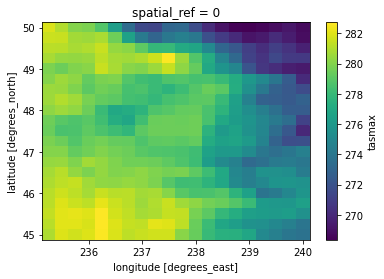

In [131]:
fine_pred.tasmax.plot()

In [117]:
# masked = np.ma.masked_array(rmse.transpose, ~mask)
# ind = np.argsort(masked, axis=1)[:, :n_analogs]

# x = X_train.reshape(ndays_in_obs, n_pixel_coarse)[ind]
# assert x.shape == (ndays_in_gcm, n_analogs, n_pixel_coarse)

# # y_train == (ndays_in_gcm, n_lat_coarse, n_lon_coarse)
# y = y_train.reshape(ndays_in_gcm, n_pixel_coarse)
# assert y.shape == (ndays_in_gcm, n_pixel_coarse)

In [ ]:
# interpolate: 1) errors, 2) trend, apply both to the fine prediction 

In [ ]:
# do another bias correction 